In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# TensorNetwork class
class TensorNetwork:
    def __init__(self, graph, tensors):
        self.graph = graph
        self.tensors = tensors
        self.index_dims = {}
        self.index_to_tensors = {}

        for name, (tensor, indices) in tensors.items():
            for idx, dim in zip(indices, tensor.shape):
                if idx in self.index_dims:
                    assert self.index_dims[idx] == dim, f"index {idx} has inconsistent dimension"
                else:
                    self.index_dims[idx] = dim
                self.index_to_tensors.setdefault(idx, []).append((name, tensor, indices))

# evaluate configuration
def evaluate_config(network, config):
    result = 1.0
    for name, (tensor, inds) in network.tensors.items():
        key = tuple(config[i] for i in inds)
        result *= tensor[key]
    return result

# Glauber update
def update_edge(network, config, idx, beta=1.0):
    tensors = network.index_to_tensors[idx]
    dim = network.index_dims[idx]
    probs = np.ones(dim)
    for name, arr, inds in tensors:
        slc = [config[i] if i != idx else slice(None) for i in inds]
        probs *= arr[tuple(slc)] ** beta
    probs = probs / probs.sum() if probs.sum() > 0 else np.ones(dim) / dim
    config[idx] = np.random.choice(dim, p=probs)

# contraction estimate with live plot
def estimate_contraction(net       : TensorNetwork,
                         betas     : np.ndarray,
                         iters     : int  = 10_000,
                         burns     : int  = 1_000,
                         n_rounds  : int  = 5,
                         verbose   : bool = True):
    """
    Return
        Z_est      : float
        logZ_traj  : list[float]  (after each β step)
        weights_by_beta : list[np.ndarray]   (flattened weights per β)
    """
    logZ_sum       = 0.0
    logZ_traj      = []
    weights_by_beta = []

    index_list = list(net.index_dims)

    for i in range(1, len(betas)):
        beta_prev, beta_curr = betas[i-1], betas[i]
        delta_beta            = beta_curr - beta_prev
        all_weights = []

        for _ in range(n_rounds):
            cfg = {idx: np.random.randint(d) for idx, d in net.index_dims.items()}

            for t in range(iters):
                idx = np.random.choice(index_list)
                update_edge(net, cfg, idx, beta=beta_prev)
                if t >= burns:
                    psi = evaluate_config(net, cfg)
                    # if psi > 0:
                    #     w_list.append(psi ** (-delta_beta))    # CORRECT sign
                    weight = psi ** delta_beta
                    all_weights.append(weight)

        if len(all_weights) == 0:
            log_rho = np.NINF
            all_weights = [0.0]
            if verbose:
                print(f'[beta={beta_curr:.3f}]  NO VALID WEIGHTS SAMPLED')
        else:
            log_rho = np.log(np.mean(all_weights))

        logZ_sum += log_rho                         # ADD (not subtract)
        logZ_traj.append(logZ_sum)
        weights_by_beta.append(np.asarray(all_weights))

        if verbose:
            print(f"[beta={beta_curr:.3f}]  log rho={log_rho:+.3e} | "
                  f"cum log Z={logZ_sum:+.3e} | "
                  f"<w>={np.mean(all_weights):.4e}  var(w)={np.var(all_weights):.4e}")

    # size factor  ∏_idx d_idx
    log_size = np.sum(np.log(list(net.index_dims.values())))
    Z_est    = np.exp(logZ_sum + log_size)
    return Z_est, logZ_traj, weights_by_beta


# ---------------------------------------------------------------------
# Run several independent AIS chains and visualise convergence
# ---------------------------------------------------------------------
def run_multiple_chains(net        : TensorNetwork,
                        betas      : np.ndarray,
                        n_chains   : int  = 5,
                        iters      : int  = 10_000,
                        burns      : int  = 1_000,
                        n_rounds   : int  = 5,
                        Z_true     : float|None = None):
    estimates          = []
    logZ_trajectories  = []
    weight_variances   = []        # list of list (chain × beta)

    for c in range(n_chains):
        np.random.seed(c)
        print(f"\n==== chain {c+1}/{n_chains} ====")

        Z_hat, log_traj, w_by_beta = estimate_contraction(
            net, betas, iters, burns, n_rounds, verbose=False
        )

        estimates.append(Z_hat)
        logZ_trajectories.append(log_traj)

        rel_sig = [ (np.std(w)/np.mean(w)) if np.mean(w) > 0 else 0.0
                    for w in w_by_beta ]
        weight_variances.append(rel_sig)

    # ---------- 1) cumulative log-Z trajectories ----------------------- #
    plt.figure(figsize=(12, 3.8))
    for k, traj in enumerate(logZ_trajectories, 1):
        plt.plot(betas[1:], traj, label=f"chain {k}", alpha=0.8)
    plt.xlabel(r"$\beta$")
    plt.ylabel(r"$\log Z$ (cum.)")
    plt.title("log-Z convergence across chains")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # ---------- 2) relative sigma(w) per beta -------------------------------- #
    plt.figure(figsize=(12, 3.8))
    for k, rel_sig in enumerate(weight_variances, 1):
        plt.plot(betas[1:], rel_sig, label=f"chain {k}", alpha=0.8)
    plt.xlabel(r"$\beta$")
    plt.ylabel(r"rel $\sigma(w)$")
    plt.title("weight dispersion vs beta")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # ---------- 3) final-estimate statistics -------------------------- #
    est_mean, est_std = np.mean(estimates), np.std(estimates)
    rel_var           = est_std / est_mean if est_mean > 0 else float("nan")
    print(f"\nFinal relative variance of $\hat Z$: {rel_var:.4e}")

    if Z_true is not None:
        rel_errs = [abs(z - Z_true)/abs(Z_true) for z in estimates]
        plt.figure(figsize=(5.5, 4))
        plt.bar(range(1, n_chains+1), rel_errs)
        plt.xlabel("chain"); plt.ylabel("rel error")
        plt.title("final relative error per chain")
        plt.grid(True); plt.tight_layout(); plt.show()

        print(f"True  Z   : {Z_true:.6f}")
        print(f"Mean  Ẑ  : {est_mean:.6f}  ± {est_std:.6f}")
        print(f"Mean rel error: {np.mean(rel_errs):.2%}")

    return est_mean, est_std

<>:150: SyntaxWarning: invalid escape sequence '\h'
<>:150: SyntaxWarning: invalid escape sequence '\h'
/var/folders/nf/hy2hshms2_v1kl4rj3cq7q840000gn/T/ipykernel_52501/3874051695.py:150: SyntaxWarning: invalid escape sequence '\h'
  print(f"\nFinal relative variance of $\hat Z$: {rel_var:.4e}")



==== chain 1/5 ====

==== chain 2/5 ====

==== chain 3/5 ====

==== chain 4/5 ====

==== chain 5/5 ====


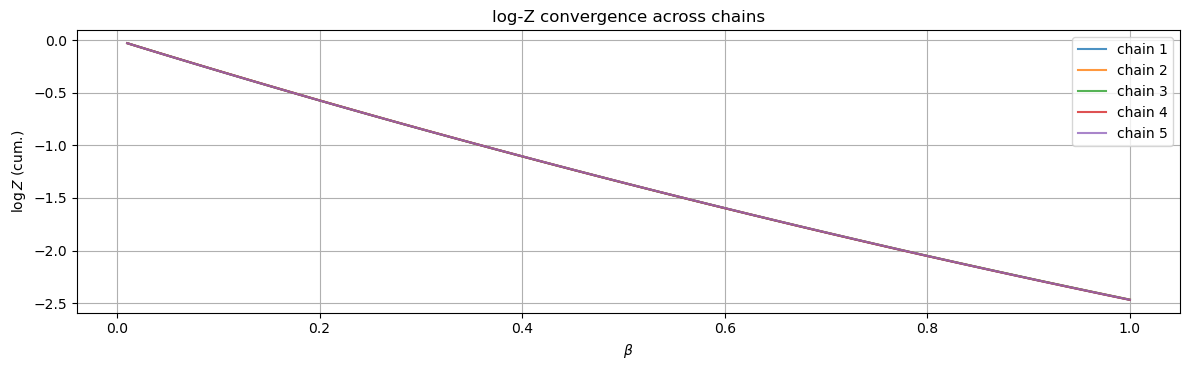

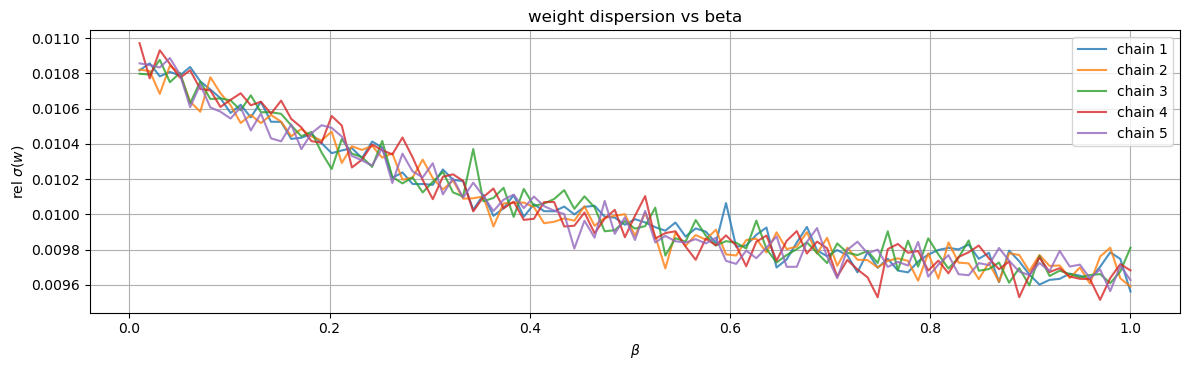


Final relative variance of $\hat Z$: 1.0260e-03


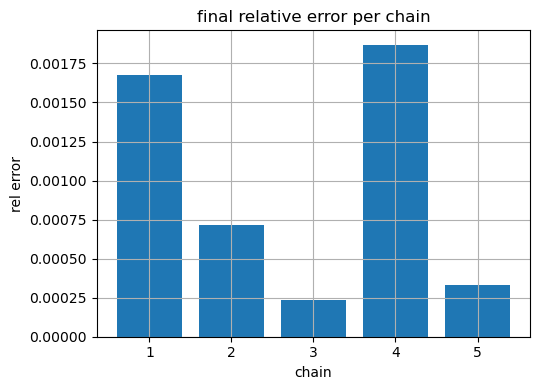

True  Z   : 6.871778
Mean  Ẑ  : 6.867756  ± 0.007046
Mean rel error: 0.10%

================== Final Summary ==================
True Tr(ABCD): 6.871778
Estimated Tr(ABCD): 6.867756 ± 0.007046
Relative error: 0.0585%


In [9]:
# test on 2x2 ring (Tr(ABCD))
def test_trace_ABCD(dim=3, betas=np.linspace(0, 1, 100), n_chains=5, iters=10000, burns=900, n_rounds=5):
    # create 2x2 ring tensor network
    G = nx.Graph()
    G.add_edges_from([
        ('A', 'B'), ('B', 'C'),
        ('C', 'D'), ('D', 'A'),
    ])

    # random positive tensors
    A, B, C, D = [np.random.rand(dim, dim) + 0.1 for _ in range(4)]
    tensors = {
        'A': (A, ['i', 'j']),
        'B': (B, ['j', 'k']),
        'C': (C, ['k', 'l']),
        'D': (D, ['l', 'i'])
    }

    # true value
    true_trace = np.trace(A @ B @ C @ D)

    # build network
    tn = TensorNetwork(G, tensors)

    # run multiple MCMC chains with live plots
    mean_Z, std_Z = run_multiple_chains(
        tn, betas, n_chains=n_chains, iters=iters, burns=burns,
        n_rounds=n_rounds, Z_true=true_trace
    )

    # summary
    print("\n================== Final Summary ==================")
    print(f"True Tr(ABCD): {true_trace:.6f}")
    print(f"Estimated Tr(ABCD): {mean_Z:.6f} ± {std_Z:.6f}")
    print(f"Relative error: {abs(mean_Z - true_trace) / abs(true_trace):.4%}")
    print("====================================================")

# run the test
test_trace_ABCD()


==== chain 1/5 ====

==== chain 2/5 ====

==== chain 3/5 ====

==== chain 4/5 ====

==== chain 5/5 ====


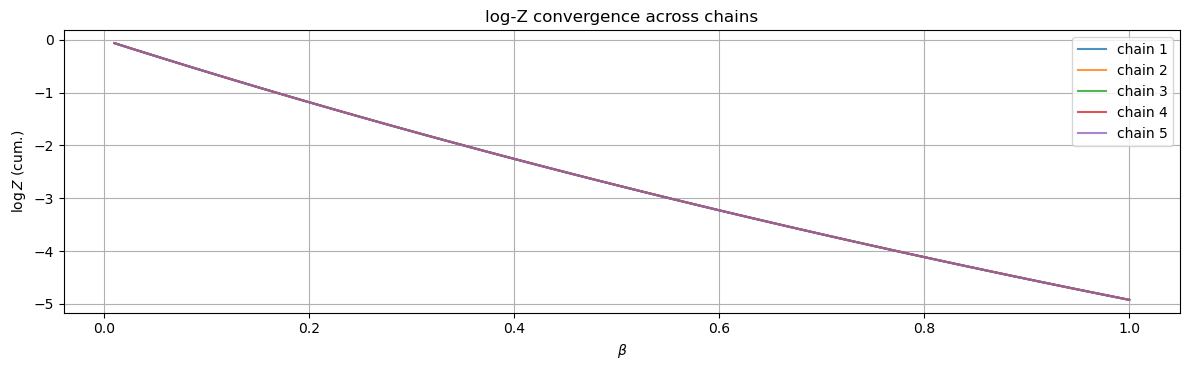

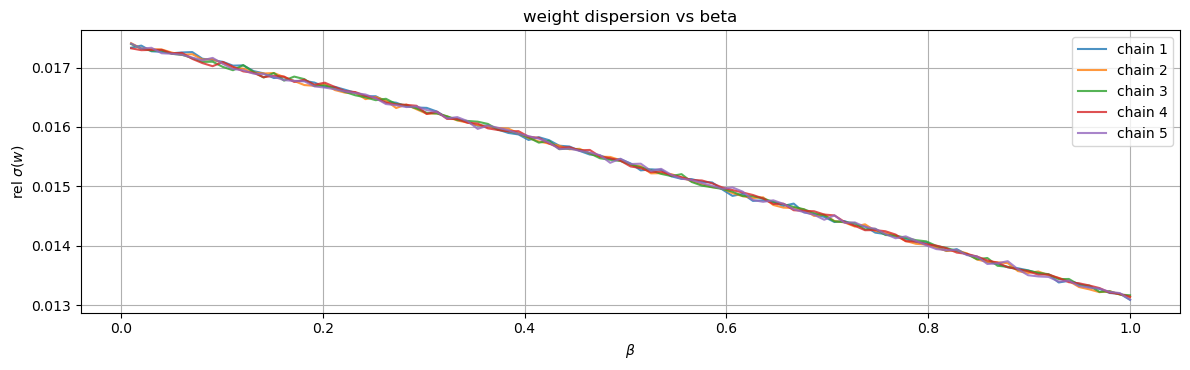


Final relative variance of $\hat Z$: 6.0412e-04

================== Final Summary ==================
Estimated Z (3x3 grid): 3868.327735 ± 2.336919


In [3]:
def build_3x3_grid_test(dim=3):
    import itertools

    G = nx.Graph()
    tensors = {}

    # define 3x3 grid coordinates
    grid_size = 3
    node_names = {(i, j): f"T{i}{j}" for i in range(grid_size) for j in range(grid_size)}

    # helper to create unique index labels
    def edge_index(i1, j1, i2, j2):
        return f"{i1}{j1}_{i2}{j2}"

    # build edges and tensors
    for i in range(grid_size):
        for j in range(grid_size):
            name = node_names[(i, j)]
            neighbors = []

            # connect to right
            if j + 1 < grid_size:
                nbr = node_names[(i, j+1)]
                idx = edge_index(i, j, i, j+1)
                G.add_edge(name, nbr)
                neighbors.append(idx)

            # connect to down
            if i + 1 < grid_size:
                nbr = node_names[(i+1, j)]
                idx = edge_index(i, j, i+1, j)
                G.add_edge(name, nbr)
                neighbors.append(idx)

            # include connections *from* left and top
            if j > 0:
                neighbors.append(edge_index(i, j-1, i, j))
            if i > 0:
                neighbors.append(edge_index(i-1, j, i, j))

            # sort for consistency
            neighbors = sorted(neighbors)
            shape = (dim,) * len(neighbors)
            data = np.random.rand(*shape) + 0.1  # ensure positivity
            tensors[name] = (data, neighbors)

    return G, tensors

# test on 3x3 grid tensor network
def test_trace_3x3_grid(dim=3,
                        betas=np.linspace(0, 1, 100),
                        n_chains=5,
                        iters=20000,
                        burns=2000,
                        n_rounds=50):
    # build 3x3 grid tensor network
    G, tensors = build_3x3_grid_test(dim=dim)

    # no exact contraction known for general 3x3 network
    tn = TensorNetwork(G, tensors)

    # run multiple MCMC chains
    mean_Z, std_Z = run_multiple_chains(
        tn, betas,
        n_chains=n_chains,
        iters=iters,
        burns=burns,
        n_rounds=n_rounds,
        Z_true=None
    )

    # summary
    print("\n================== Final Summary ==================")
    print(f"Estimated Z (3x3 grid): {mean_Z:.6f} ± {std_Z:.6f}")
    print("====================================================")

# run it
test_trace_3x3_grid()

In [4]:
Z_true = contract_tensor_network(G, tensors)
print(f"True Z (3x3 grid): {Z_true:.6f}")

True Z (3x3 grid): 4096.000000


NameError: name 'mean_Z' is not defined